In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# importing the dataset
reviews_df = pd.read_csv('/content/drive/MyDrive/ML Projects/Customer-Sentiment-Analysis/amazon_alexa.tsv', sep='\t')
reviews_df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
reviews_df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


## **Exploring the Dataset**

In [4]:
reviews_df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f421167da90>,
      dtype=object)

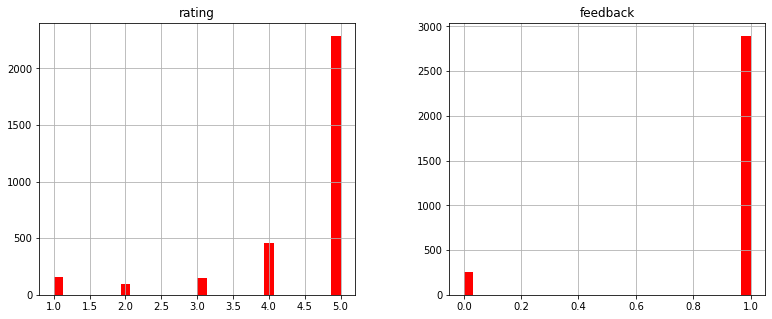

In [5]:
reviews_df.hist(bins = 30, figsize = (13,5), color = 'r')

In [6]:
reviews_df['length'] = reviews_df['verified_reviews'].apply(len)
reviews_df

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5
...,...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1,50
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1,135
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1,441
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1,380


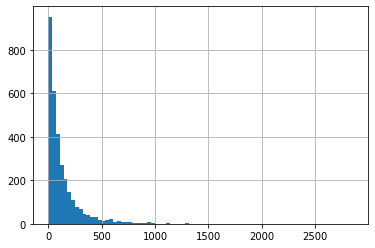

In [7]:
reviews_df['length'].hist(bins = 80)

In [8]:
reviews_df['length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [9]:
# longest & shortest review
reviews_df[reviews_df['length'] == 2851]['verified_reviews']

2016    Incredible piece of technology.I have this rig...
Name: verified_reviews, dtype: object

In [10]:
reviews_df[reviews_df['length'] == 1]['verified_reviews']

60      😍
85       
183      
219      
374      
       ..
3114     
3120     
3123     
3126     
3141     
Name: verified_reviews, Length: 81, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


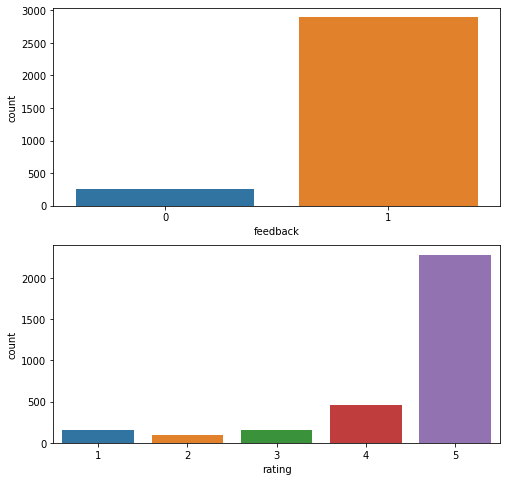

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
sns.countplot(reviews_df['feedback'], label = "Count") 
plt.subplot(2, 1, 2)
sns.countplot(reviews_df['rating'], label='rating')

In [12]:
len(reviews_df['verified_reviews'])

3150

In [13]:
# performing OneHotEncoding

variation_df = pd.get_dummies(reviews_df['variation'], drop_first = True)
reviews_df.drop(['variation', 'date','length'],  axis=1, inplace=True)
reviews_df = pd.concat([variation_df, reviews_df], axis = 1)
reviews_df

,Black Dot,Black Plus,Black Show,Black Spot,Charcoal Fabric,Configuration: Fire TV Stick,Heather Gray Fabric,Oak Finish,Sandstone Fabric,Walnut Finish,White,White Dot,White Plus,White Show,White Spot,rating,verified_reviews,feedback
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,Love my Echo!,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,Loved it!,1
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,"Sometimes while playing a game, you can answer...",1
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,I have had a lot of fun with this thing. My 4 ...,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,Music,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,"Perfect for kids, adults and everyone in betwe...",1
3146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,"Listening to music, searching locations, check...",1
3147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,"I do love these things, i have them running my...",1
3148,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,Only complaint I have is that the sound qualit...,1


In [14]:
# func to create the list of procecssed reviews 
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')


def create_corpus(data):
  corpus = []
  for i in range(0, data.shape[0]):
    review = data.iloc[i, -2]
    review = re.sub('[^a-zA-Z]', " ", review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if word not in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

  return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
train_corpus = create_corpus(reviews_df)

In [16]:
from sklearn.feature_extraction.text import  CountVectorizer
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(train_corpus).toarray()
y = reviews_df.iloc[:, -1].astype(int)

In [17]:
reviews_df.drop(['verified_reviews', 'feedback'], axis = 1, inplace = True)

In [18]:
X = np.concatenate([X, reviews_df.iloc[:, :]], axis = 1)
X.shape

(3150, 2516)

In [19]:
# creating training & validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [20]:
# initialising the NaiveBayes Classifier
import xgboost
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
# analysing model performance
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 109,    0],
       [   0, 1151]])

In [22]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00      1151

    accuracy                           1.00      1260
   macro avg       1.00      1.00      1.00      1260
weighted avg       1.00      1.00      1.00      1260

